In [1]:
import pandas as pd

In [2]:
full_df = pd.read_csv("../data/spotify.csv")
df = full_df[["energy", "tempo", "loudness"]]

In [3]:
from sklearn.preprocessing import StandardScaler

class ZScoreNormalizer(StandardScaler):
    def get_name(self):
        return "z-score"
    
class RangeNormalizer:
    def get_name(self):
        return "range"

    def fit_transform(self, data):
        means = data.mean(axis=0)
        mins = data.min(axis=0)
        maxs = data.max(axis=0)
        return (data - means) / (maxs - mins)

In [4]:
from scipy.linalg import svd

for normalizer in [ZScoreNormalizer(), RangeNormalizer()]:
    ndf = normalizer.fit_transform(df.values)
    data_scatter = (ndf ** 2).sum()
    U, s, Vh = svd(ndf, full_matrices=False)
    natural_contributions = s ** 2
    percent_contributions = (s ** 2) / data_scatter * 100
    print(normalizer.get_name())
    print(data_scatter)
    print(natural_contributions)
    print(percent_contributions)

z-score
6051.0
[3681.15979412 1890.2710192   479.56918668]
[60.83556097 31.23898561  7.92545342]
range
167.56804862334135
[111.82794569  46.37230045   9.36780248]
[66.73584052 27.67371276  5.59044672]


In [5]:
from sklearn.preprocessing import MinMaxScaler

import numpy as np

ndf = MinMaxScaler(feature_range=(0, 100)).fit_transform(df)
U, s, Vh = svd(ndf, full_matrices=False)
ranks = ndf @ (-Vh[0])
ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min()) * 100
print(np.sort(ranks)[:5])
print(np.sort(ranks)[::-1][:5])

[ 0.          3.61861888  4.30979486  6.32921304 10.25939549]
[100.          98.28891959  97.66954003  97.66664262  97.27050975]


In [6]:
full_df.iloc[np.argsort(-ranks)].head(5)

Unnamed: 0  acousticness  danceability  duration_ms  energy  \
1443        1443      0.000679         0.503       249655   0.989   
1121        1121      0.086900         0.490       246853   0.894   
532          532      0.000034         0.123        99413   0.963   
1106        1106      0.206000         0.746       227457   0.961   
195          195      0.613000         0.698       230200   0.878   

      instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
1443          0.542000    6     0.548    -0.787     1       0.0650  174.012   
1121          0.000000   11     0.103    -1.708     0       0.0947  197.989   
532           0.032900   10     0.292    -4.182     1       0.0543  198.040   
1106          0.000002    0     0.329    -2.243     1       0.1300  179.984   
195           0.000016    8     0.518    -0.307     1       0.3140  182.126   

      time_signature  valence  target                             song_title  \
1443             4.0    0.615       0                               The Wall   
1121             4.0    0.656       0  Qué Gano Olvidándote - Versión Urbana   
532              4.0    0.680       1                        Wake Bake Skate   
1106             4.0    0.954       0                           La Bicicleta   
195              4.0    0.816       1                           GodLovesUgly   

                    artist  
1443  Matrix & Futurebound  
1121                  Reik  
532                 FIDLAR  
1106          Carlos Vives  
195             Atmosphere

In [7]:
full_df.iloc[np.argsort(ranks)].head(5)

Unnamed: 0  acousticness  danceability  duration_ms  energy  \
1531        1531         0.940         0.317       234373  0.0302   
1594        1594         0.995         0.471        82293  0.0148   
1549        1549         0.971         0.450       289693  0.0437   
1596        1596         0.995         0.333       221173  0.0288   
1876        1876         0.994         0.206       336000  0.0347   

      instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
1531             0.298    1    0.0792   -30.447     1       0.0342   47.859   
1594             0.934    3    0.1810   -33.097     1       0.0558  102.271   
1549             0.880   10    0.0948   -29.460     1       0.0374   63.938   
1596             0.819    1    0.0730   -31.367     1       0.0423  100.189   
1876             0.828    1    0.1310   -25.351     1       0.0431   67.584   

      time_signature  valence  target  \
1531             4.0   0.1550       0   
1594             3.0   0.1830       0   
1549             4.0   0.0906       0   
1596             3.0   0.0857       0   
1876             4.0   0.0378       0   

                                     song_title           artist  
1531  I Was So Young, and You Were So Beautiful     Bill Charlap  
1594    Lyric Pieces, Book I Op. 12: I. Arietta     Edvard Grieg  
1549                                    Eleanor       Hank Jones  
1596    8 Fantasiestücke, Op.12 : 1. Des Abends  Robert Schumann  
1876   Nocturne No.1 In B Flat Minor, Op.9 No.1  Frédéric Chopin

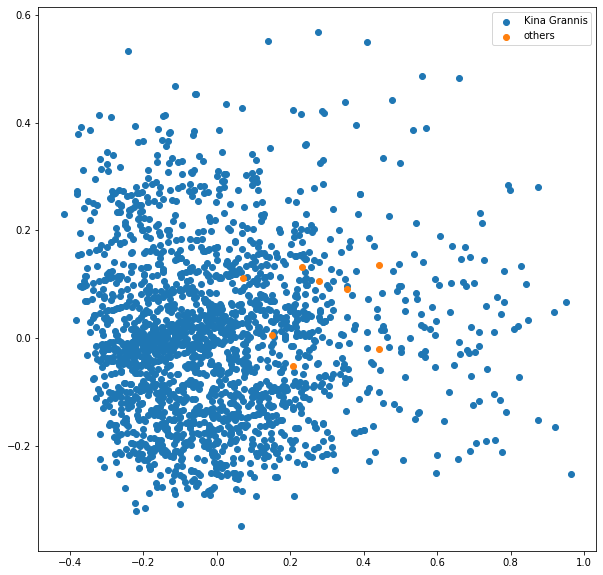

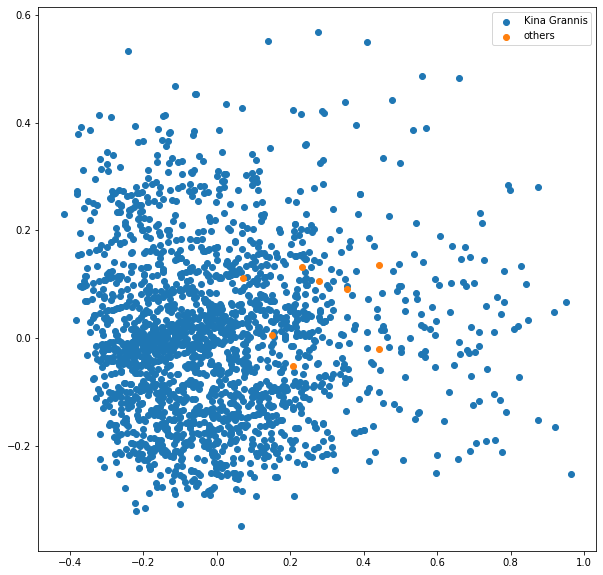

In [51]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

for normalizer in [ZScoreNormalizer(), RangeNormalizer()]:
    ARTIST = 'Kina Grannis'
    ndf = normalizer.fit_transform(df.values)
    pca_df = PCA(n_components=2, svd_solver='full').fit_transform(ndf)

    plt.figure(figsize=(10, 10))
    
    artists = full_df['artist'].values

    artist = np.where(artists == ARTIST)
    artist_pca = pca_df[artist]
    
    others = np.where(artists != ARTIST)
    others_pca = pca_df[others]
    plt.scatter(artist_pca[:, 0], artist_pca[:, 1], label=ARTIST)
    plt.scatter(others_pca[:, 0], others_pca[:, 1], label='others')
    plt.legend()

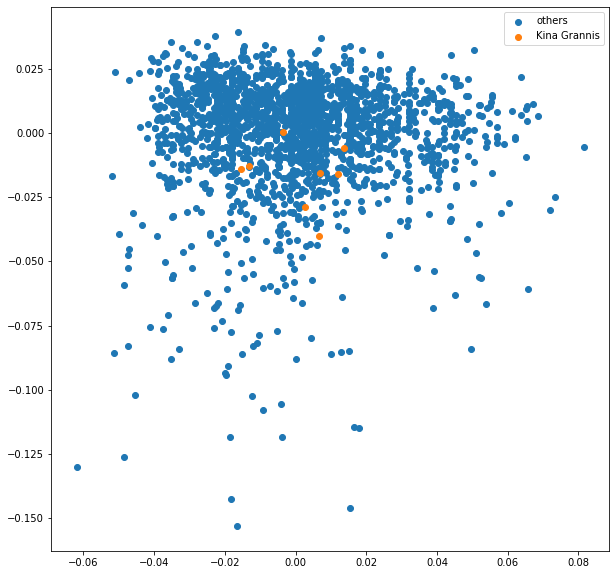

In [70]:
N = df.shape[0]
ndf = (df - df.mean(axis=0)).values

pcs = []

cov = ndf.T @ ndf / N
for i in range(2):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    max_eigenvalue = eigenvalues.max()
    max_eigenvector = eigenvectors[:, eigenvalues.argmax()]
    pcs.append(ndf @ max_eigenvector / np.sqrt(max_eigenvalue * N))
    cov -= max_eigenvalue * (max_eigenvector[:, None] @ max_eigenvector[None, :])

ARTIST = 'Kina Grannis'
artists = full_df['artist'].values
artist = np.where(artists == ARTIST)
others = np.where(artists != ARTIST)

plt.figure(figsize=(10, 10))
plt.scatter(pcs[0][others], pcs[1][others], label='others')
plt.scatter(pcs[0][artist], pcs[1][artist], label=ARTIST)

plt.legend()